In [ ]:
TRIAL_NUMBER = 1

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#### https://www.youtube.com/watch?v=SQ1iIKs190Q&list=PL-wATfeyAMNoirN4idjev6aRu8ISZYVWm&index=8
import torch
import torchaudio
import torchvision
from torch import nn
from torchinfo import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!tar -xf /content/drive/MyDrive/UrbanSound8K.tar.gz

In [ ]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 5 conv blocks(conv leakyRelu maxpool) / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1,
                out_channels = 16,
                kernel_size = 3,
                stride = 1,
                padding = 2
            ),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)     
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 3,
                stride = 1,
                padding = 2
            ),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)     
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels = 32,
                out_channels = 32,
                kernel_size = 3,
                stride = 1,
                padding = 2
            ),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)     
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels = 32,
                out_channels = 64,
                kernel_size = 3,
                stride = 1,
                padding = 2
            ),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)     
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels = 64,
                out_channels = 64,
                kernel_size = 3,
                stride = 1,
                padding = 2
            ),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)     
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(576, 32)
        self.fc2 = nn.Linear(32, 10)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.fc1(x)
        logits = self.fc2(x)
        predictions = self.softmax(logits)
        return predictions
        
        
if __name__ == "__main__":
    cnn = CNNNetwork()
    print(summary(cnn, (1,1, 64, 44)))

Layer (type:depth-idx)                   Output Shape              Param #
CNNNetwork                               [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 33, 23]           --
│    └─Conv2d: 2-1                       [1, 16, 66, 46]           160
│    └─LeakyReLU: 2-2                    [1, 16, 66, 46]           --
│    └─MaxPool2d: 2-3                    [1, 16, 33, 23]           --
├─Sequential: 1-2                        [1, 32, 17, 12]           --
│    └─Conv2d: 2-4                       [1, 32, 35, 25]           4,640
│    └─LeakyReLU: 2-5                    [1, 32, 35, 25]           --
│    └─MaxPool2d: 2-6                    [1, 32, 17, 12]           --
├─Sequential: 1-3                        [1, 32, 9, 7]             --
│    └─Conv2d: 2-7                       [1, 32, 19, 14]           9,248
│    └─LeakyReLU: 2-8                    [1, 32, 19, 14]           --
│    └─MaxPool2d: 2-9                    [1, 32, 9, 7]             --
├─Sequen

In [ ]:
import os

import torch
from torch.utils.data import Dataset
import pandas as pd
import soundfile
import torchaudio


class UrbanSoundDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        signal = (signal - signal.mean())/signal.std() # normalize
        #signal = signal/signal.max() # scale to 1 max
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:

            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(device)

            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        fold = f"fold{self.annotations.iloc[index, 5]}"
        path = os.path.join(self.audio_dir, fold, self.annotations.iloc[
            index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]


ANNOTATIONS_FILE = "/content/UrbanSound8K/metadata/UrbanSound8K.csv"
AUDIO_DIR = "/content/UrbanSound8K/audio"
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

usd = UrbanSoundDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)
print(f"There are {len(usd)} samples in the dataset.")
print(str(torchaudio.get_audio_backend()))
signal, label = usd[0]


Using device cuda
There are 8732 samples in the dataset.
sox_io


In [ ]:
import librosa
import matplotlib.pyplot as plt
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [ ]:
torch.manual_seed(TRIAL_NUMBER)

In [ ]:
train_set, test_set = torch.utils.data.random_split(usd, [7732, 1000])

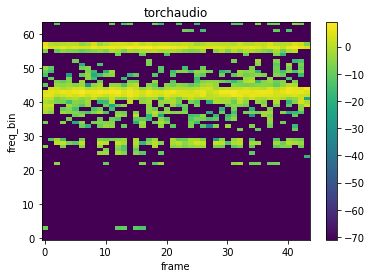

In [ ]:
plot_spectrogram(train_set[2222][0].to("cpu")[0], title="torchaudio")

In [ ]:
model_path = "feedforwardnet_FINAL_trial_%i.pth"%TRIAL_NUMBER
print(model_path)

feedforwardnet_FINAL_trial_1.pth


In [ ]:
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader

#from urbansounddataset import UrbanSoundDataset
#from cnn import CNNNetwork


BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001

ANNOTATIONS_FILE = "/content/UrbanSound8K/metadata/UrbanSound8K.csv"
AUDIO_DIR = "/content/UrbanSound8K/audio"
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050

loss_list = []


def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader


def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)

        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, target)

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"loss: {loss.item()}")
    loss_list.append(loss.item())


def train(model, data_loader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_single_epoch(model, data_loader, loss_fn, optimiser, device)
        print("---------------------------")
    print("Finished training")


if __name__ == "__main__":

    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using {device}")

    # instantiating our dataset object and create data loader
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )

    train_dataloader = create_data_loader(train_set, BATCH_SIZE)

    # construct model and assign it to device
    cnn = CNNNetwork().to(device)
    print(cnn)

    # initialise loss funtion + optimiser
    loss_fn = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(cnn.parameters(),
                                 lr=LEARNING_RATE,
                                 weight_decay=5e-4)

    # train model
    train(cnn, train_dataloader, loss_fn, optimiser, device, EPOCHS)

    # save model
    torch.save(cnn.state_dict(), model_path)
    print("Trained feed forward net saved at %s" %model_path)


Using cuda
CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=

In [ ]:
import torch
import torchaudio

#from cnn import CNNNetwork
#from urbansounddataset import UrbanSoundDataset
#from train import AUDIO_DIR, ANNOTATIONS_FILE, SAMPLE_RATE, NUM_SAMPLES


class_mapping = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"
]


def predict(model, input, target, class_mapping):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    with torch.no_grad():
        predictions = model(input)
        # Tensor (1, 10) -> [ [0.1, 0.01, ..., 0.6] ]
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected


# load back the model
cnn = CNNNetwork()
state_dict = torch.load(model_path)
cnn.load_state_dict(state_dict)

# load urban sound dataset dataset
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

usd = UrbanSoundDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        "cpu")


# get a sample from the urban sound dataset for inference
input, target = test_set[0][0], test_set[0][1] # [batch size, num_channels, fr, time]
input.unsqueeze_(0)

# make an inference
predicted, expected = predict(cnn, input, target,
                              class_mapping)
print(f"Predicted: '{predicted}', expected: '{expected}'")

Predicted: 'air_conditioner', expected: 'air_conditioner'


In [ ]:
sumRight = 0
for i in range(1000):
    input, target = train_set[i][0], train_set[i][1]
    input.unsqueeze_(0)

    # make an inference
    predicted, expected = predict(cnn, input, target,
                                  class_mapping)
    if predicted == expected:
        sumRight += 1

In [ ]:
sumRight/1000

0.876

In [ ]:
sumRight = 0
for i in range(1000):
    input, target = test_set[i][0], test_set[i][1]
    input.unsqueeze_(0)

    # make an inference
    predicted, expected = predict(cnn, input, target,
                                  class_mapping)
    if predicted == expected:
        sumRight += 1

In [ ]:
sumRight/1000

0.726

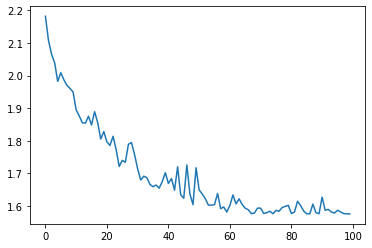

In [ ]:
from matplotlib import pyplot as plt
plt.plot(loss_list)
plt.show()

In [ ]:
!cp {model_path} "/content/drive/My Drive/"